In [1]:
#import necessary libraries
import gym
import numpy as np


Choose the environment that the agent will explore and train on. 
In our case, we choose a 4x4 grid of icy lake with holes where the agent can fall into.
Success in our case is defined as the successful crossing of the icy lake without falling into holes.
![convert notebook to web app](https://www.gymlibrary.dev/_images/frozen_lake.gif)



In [2]:
side = 4
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)

Below we define the functions used in the learning process. The idea is to propagate the information from the exploring agent throughout the state-value and action value functions. The implementation follows the notions from the Sutton and Barto RL learning textbook. In fewer than 10 iterations, the algorithm learns to navigate around the maze.

In [3]:
def get_possible_states(current_state,horizontal_grid_size,vertical_grid_size):
    y_pos = np.mod(current_state,vertical_grid_size)
    x_pos = int(current_state/horizontal_grid_size)
    y_positions = np.array([y_pos+1, y_pos, y_pos-1,y_pos])
    x_positions = np.array([x_pos,x_pos-1,x_pos,x_pos+1])
    do_not_keep = (x_positions <0)| (x_positions>horizontal_grid_size-1)| (y_positions < 0 ) | (y_positions > vertical_grid_size-1)

    
    keep_y = np.where((x_positions <0)|(x_positions>horizontal_grid_size-1), x_positions, x_positions[x_pos])+1 ==1

    x_positions = x_positions[do_not_keep==False]
    y_positions = y_positions[do_not_keep==False]
    
    state_indices = x_positions*vertical_grid_size + np.mod(y_positions,horizontal_grid_size)
    return state_indices

In [3]:
def run_policy_iteration(delta_thresh, value_thresh):

    env = init_env()
    policy = init_policy()
    state_values = calculate_state_values(policy, env, value_thresh)
    delta = delta_thresh
    
    while delta >= delta_thresh:
        policy = update_policy(policy, state_values)
        new_state_values = calculate_state_values(policy, env, value_thresh)
        delta = state_values - new_state_values
        state_values = new_state_values
    return policy
    
def init_state_values(n):
    """
    Initializes values to zeros for all states
    where n is the number of states
    """
    return np.zeros(n)

def calculate_state_values(env, delta_thresh=0.001, gamma=0.9):
    
    env.reset()
    env.unwrapped.s = 0 # begin at the upper left corner
    state_values = init_state_values(env.observation_space.n)
    deltas = np.ones(env.observation_space.n)*1000 # compute deltas for each state
    
    i = 0
    
    
    while deltas.max() >= delta_thresh:
        for state in range(env.observation_space.n): # iterate sequentially over state space
            env.reset()
            env.unwrapped.s = state
            action_value_estimate = {} # action value for current state stored as action:value pairs
            for action in range(env.action_space.n):
                
                new_state, reward, terminated, _ = env.step(action)
                
                env.unwrapped.s = state # move the agent back to the state being computed

                if terminated == 1:
                    action_value_estimate[action] = (reward + (gamma*state_values[new_state]))
                else:
                    action_value_estimate[action] = (reward + (gamma*state_values[new_state]))

            best_value = max(action_value_estimate.values())
            
            deltas[state] = abs(state_values[state] - best_value)
            state_values[state] = best_value

            
        i += 1
            
    return state_values

def calculate_policy(env, delta_thresh=0.001, gamma=0.9):
    
    env.reset()
    env.unwrapped.s = 0 # begin at the upper left corner
    state_values = init_state_values(env.observation_space.n)
    deltas = np.ones(env.observation_space.n)*1000 # compute deltas for each state
    action_values = {}
    i = 0
    
    
    while deltas.max() >= delta_thresh:
        for state in range(env.observation_space.n): # iterate sequentially over state space
            env.reset()
            env.unwrapped.s = state
            action_value_estimate = {} # action value for current state stored as action:value pairs
            for action in range(env.action_space.n):
                
                new_state, reward, terminated, _ = env.step(action)
                
                env.unwrapped.s = state # move the agent back to the state being computed

                action_value_estimate[action] = (reward + (gamma*state_values[new_state]))
                
            action_values[state] = action_value_estimate #store action values
            best_value = max(action_value_estimate.values())
            
            deltas[state] = abs(state_values[state] - best_value)
            state_values[state] = best_value

            
        i += 1
            
    return action_values

Finally, we run the algorithm to compute the value of each state and the associated action values.
It converges quickly and the results are stored in dictoionaries below. The heatmap below shows that its very advantageous to be in state (2,3) which is the pre-terminal state of the grid and not very advantageous to be in the ice holes, marked by black colour. The state value does not update upon termination, hence the state value of the terminal goal state (3,3) remains low.

In [18]:
state_values = calculate_state_values(env)
action_values = calculate_policy(env, delta_thresh=0.1, gamma=0.9)

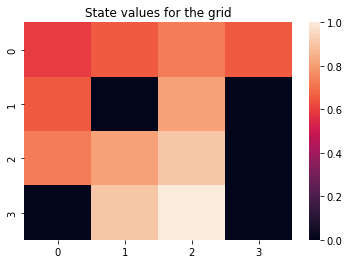

In [21]:
import seaborn as sb

sb.heatmap(state_values.reshape((4,4))).set(title= "State values for the grid")

